<a href="https://colab.research.google.com/github/m1chae11u/Deep-CNN-2D-Floor-Plan-Classifier/blob/main/Deep_CNN_Image_Classifier_For_2D_Room_Layouts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [4]:
import tensorflow as tf
import os

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU') #shows all gpus available
#this is telling tensorflow to limit the memory consumption
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# **Remove Bad Images**

In [6]:
import cv2
import imghdr

In [7]:
data_dir = '/content/data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list /content/data/2d-living-spaces/.DS_Store
Image not in ext list /content/data/2d-living-spaces/0f9927d4f1226162f619204b9a1d260bb2a2ba6a_2_666x500.gif
Image not in ext list /content/data/2d-living-spaces/4871-1stfloor.webp
Image not in ext list /content/data/2d-living-spaces/top-view-plan.gif
Image not in ext list /content/data/2d-living-spaces/a5df11186097009.Y3JvcCw1MDAwLDM5MTAsMCwyOTc.jpg
Image not in ext list /content/data/2d-living-spaces/s-l12002.webp
Image not in ext list /content/data/2d-living-spaces/518d6095b4e092bda51d35169c5f3b98.gif
Image not in ext list /content/data/2d-living-spaces/30253240223_d92127d7ef_z.jpg
Image not in ext list /content/data/2d-office-spaces/CHOPTANK-CONFERENCE-16.jpg
Image not in ext list /content/data/2d-office-spaces/.DS_Store
Image not in ext list /content/data/2d-office-spaces/8cff04e3ac2b4d0d8b0c3e154fd3fb77.webp


Load Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
#building data pipeline
data = tf.keras.utils.image_dataset_from_directory('/content/data')

Found 1079 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

In [13]:
batch[0].shape

(32, 256, 256, 3)

In [14]:
# Class 1 = 2D Office Spaces
# Class 0 = 2D Living Spaces
batch[1]

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1], dtype=int32)

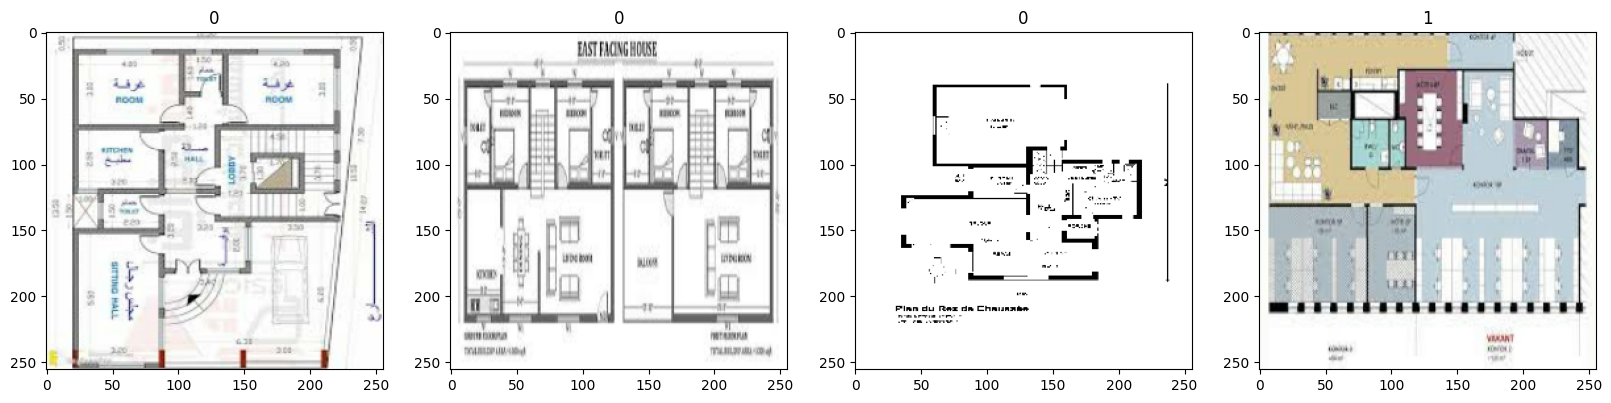

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for index, img in enumerate(batch[0][:4]):
    ax[index].imshow(img.astype(int))
    ax[index].title.set_text(batch[1][index])

# **Preprocess Data**

In [16]:
#scaling the data
data = data.map(lambda x,y: ((x/255), y)) #scales all the pixel values to between 0 and 1, map function allows us to apply the scaling transformation as the data is accessed.

In [17]:
data.as_numpy_iterator().next()

(array([[[[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843]],
 
         [[0.95957416, 0.95957416, 0.95957416],
          [0.96997386, 0.96997386, 0.96997386],
          [0.9903898 , 0.9903898 , 0.9903898 ],
          ...,
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843]],
 
         [[0.9670803 , 0.9670803 , 0.9670803 ],
          [0.97130775, 0.97130775, 0.97130775],
          [0.98510665, 0.98510665, 0.98510665],
          ...,
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843]],
 
         ...,
 
         [[0.98793656, 0.98793656, 0.98793656],
          [0.99569

In [18]:
#splitting data into training, validation, and test partition
train_size = int(len(data)*.7) #used to train our model
val_size = int(len(data)*.2) + 1 #used to evaluate our model during training and fine tune
test_size = int(len(data)*.1) + 1 #used for post training evaluation
print(len(data) == (train_size + val_size + test_size))

True


In [19]:
#data is already shuffled
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)
print(len(data) == len(train) + len(val) + len(test))

True


# **Building The Deep Learning Model**

In [20]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau

In [21]:
# Data Augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

In [23]:
model = Sequential([
    data_augmentation,  # Data augmentation layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, 256, 256, 3))  # Explicitly building the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 254, 254, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_5 (Bat  (None, 125, 125, 64)     

# **Training**

In [35]:
logdir = 'logs'
tensorboard_callback = TensorBoard(log_dir=logdir)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

hist = model.fit(
    train,
    epochs=25,
    validation_data=val,
    callbacks=[tensorboard_callback, early_stopping, reduce_lr]
)

Epoch 1/25
23/23 [==============================] - 40s 2s/step - loss: 0.3590 - accuracy: 0.8356 - val_loss: 0.5672 - val_accuracy: 0.7143 - lr: 1.0000e-04
Epoch 2/25
23/23 [==============================] - 40s 2s/step - loss: 0.4440 - accuracy: 0.7935 - val_loss: 1.1371 - val_accuracy: 0.6786 - lr: 1.0000e-04
Epoch 3/25
23/23 [==============================] - 41s 2s/step - loss: 0.4166 - accuracy: 0.8247 - val_loss: 0.5175 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 4/25
23/23 [==============================] - 40s 1s/step - loss: 0.3776 - accuracy: 0.8220 - val_loss: 0.5091 - val_accuracy: 0.7545 - lr: 1.0000e-04
Epoch 5/25
23/23 [==============================] - 40s 1s/step - loss: 0.3919 - accuracy: 0.8274 - val_loss: 0.4900 - val_accuracy: 0.8036 - lr: 1.0000e-04
Epoch 6/25
23/23 [==============================] - 40s 1s/step - loss: 0.3822 - accuracy: 0.8152 - val_loss: 0.5040 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 7/25
23/23 [==============================] - 41s 2s

# **Plot Performance**

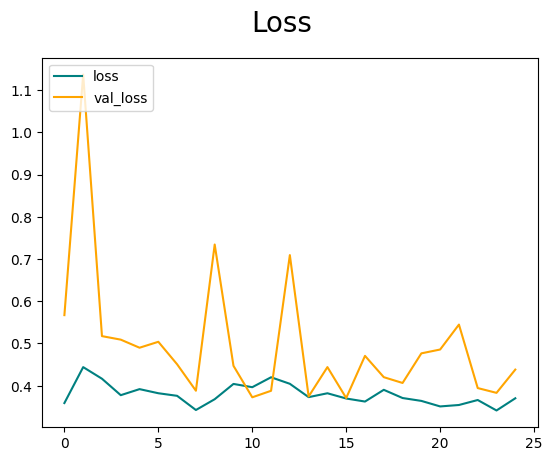

In [36]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

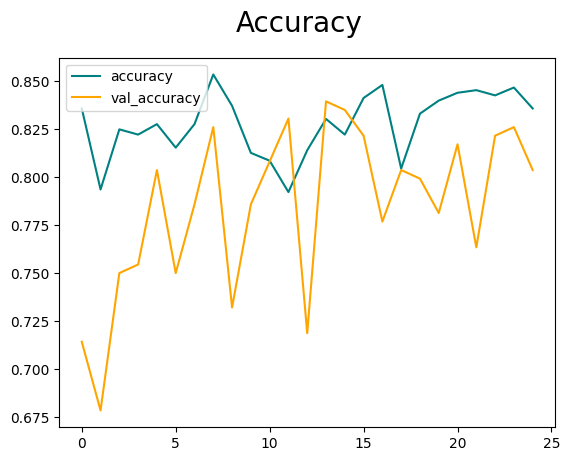

In [37]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# **Evaluate**

# **Test**